In [1]:
from sklearn.metrics.pairwise import euclidean_distances 
import tensorflow as tf
import numpy as np
import math
dtype=tf.float64

def time_kernel(X1,X2,l1,l2,sig1,sig2):
#     x1=np.delete(X1,time_axis-1,1)
#     x2=np.delete(X2,time_axis-1,1)
    col=X1.shape[1]
    
    x1=X1[:,:col-1]
    x2=X2[:,:col-1]
    x1=tf.expand_dims(x1/l1,1)
    x2=tf.expand_dims(x2/l1,0)
    sub1=tf.square(x1-x2)
    r1=tf.reduce_sum(sub1,axis=-1)
    k1=sig1  * tf.exp(-0.5 * r1)
    
    t1=X1[:,col-1:]
    t2=X2[:,col-1:]
    t1=tf.expand_dims(t1/l2,1)
    t2=tf.expand_dims(t2/l2,0)
    sub2=tf.abs(t1-t2)
    r2=tf.reduce_sum(sub2,axis=-1)
    a=np.sqrt(3)
    k2=sig2*(1.0+a*r2)*tf.exp(-a*r2)
    
    return k1*k2

# class time_GPmodel():
#     def __init__(self,data,kernel,l1,l2,sig1,sig2,likvar=0):
#         self.X = data[0]
#         self.Y = data[1]
#         self.sigma2 = likvar
#         self.kern = lambda X1,X2: kernel(X1,X2,l1,l2,sig1,sig2)
#     def coeff_creation(self):
#         # K=self.kern.K(self.X,self.X)+self.sigma2*tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64)
#         K=self.kern(self.X,self.X)+self.sigma2*tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64)
#         L=tf.linalg.cholesky(K)
#         trm1=tf.linalg.triangular_solve(L,self.Y,lower=True)
#         self.coeffmu=tf.linalg.triangular_solve(tf.transpose(L),trm1,lower=False)
#         trm2=tf.linalg.triangular_solve(L,tf.eye(self.X.shape[0],self.X.shape[0],dtype=tf.float64),lower=True)
#         self.coeffvar=tf.linalg.triangular_solve(tf.transpose(L),trm2,lower=False)
#     def predict(self,Xtst,with_var=False):
#         Kstar=self.kern(Xtst,self.X)
#         Kstarstar=self.kern(Xtst,Xtst)
#         mu=tf.matmul(Kstar,self.coeffmu)
#         if with_var:
#             var=tf.linalg.diag_part(Kstarstar)
#             var-=tf.matmul(tf.matmul(Kstar,self.coeffvar),tf.transpose(Kstar))
#             var+=self.sigma2
#             return mu,var
#         else:
#             return mu


C:\Users\Yuzhang Ge\anaconda3\envs\newenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def time_kernel1(X1,X2,l1,l2,sig1,sig2):
#     x1=np.delete(X1,time_axis-1,1)
#     x2=np.delete(X2,time_axis-1,1)
    col=X1.shape[1]
    
    x1=X1[0::3,:col-1]
    x2=X2[0::3,:col-1]
    x1=tf.expand_dims(x1/l1,1)
    x2=tf.expand_dims(x2/l1,0)
    sub1=tf.square(x1-x2)
    r1=tf.reduce_sum(sub1,axis=-1)
    k1=sig1  * tf.exp(-0.5 * r1)
    
    t1=X1[:3,col-1:]
    t2=X2[:3,col-1:]
    t1=tf.expand_dims(t1/l2,1)
    t2=tf.expand_dims(t2/l2,0)
    sub2=tf.abs(t1-t2)
    r2=tf.reduce_sum(sub2,axis=-1)
    a=np.sqrt(3)
    k2=sig2*(1.0+a*r2)*tf.exp(-a*r2)
    
    return k1,k2

In [3]:
class time_GPmodel():
    def __init__(self,data,kernel1,kernel2,l1,l2,sig1,sig2,likvar=0):
        self.X = data[0]
        self.Y = data[1]
        self.sigma2 = likvar
        self.kern = lambda X1,X2: kernel1(X1,X2,l1,l2,sig1,sig2)
        self.kern2=lambda X1,X2: kernel2(X1,X2,l1,l2,sig1,sig2)
    def coeff_creation(self):
        K1,K2=self.kern2(self.X,self.X)
        K1=K1+self.sigma2*tf.eye(290,290,dtype=tf.float64)
        L1=tf.linalg.cholesky(K1)
        trm=tf.linalg.triangular_solve(L1,tf.eye(290,290,dtype=tf.float64),lower=True)
        K1_inv=tf.linalg.triangular_solve(tf.transpose(L1),trm,lower=False)

        L2=tf.linalg.cholesky(K2)
        trm2=tf.linalg.triangular_solve(L2,tf.eye(3,3,dtype=tf.float64),lower=True)
        K2_inv=tf.linalg.triangular_solve(tf.transpose(L2),trm2,lower=False)

        op1=tf.linalg.LinearOperatorFullMatrix(K1_inv)
        op2=tf.linalg.LinearOperatorFullMatrix(K2_inv)

        self.K_inv=tf.linalg.LinearOperatorKronecker([op1,op2]).to_dense()
#         print(self.K_inv)
    def predict(self,Xtst,with_var=False):
        Kstar=self.kern(Xtst,self.X)
#         print(Kstar.shape)
        Kstarstar=self.kern(Xtst,Xtst)
        mu=tf.matmul(tf.matmul(Kstar,self.K_inv),self.Y)
        if with_var:
            var=tf.linalg.diag_part(Kstarstar)
            var-=tf.matmul(tf.matmul(Kstar,self.K_inv),tf.transpose(Kstar))
            var+=self.sigma2
            return mu,var
        else:
            return mu

                

In [4]:
import tensorflow_probability as tfp
tfd = tfp.distributions 

def LogLik(Xtst,Ytst,models,cov):
    pred=models.predict(Xtst)
#     scale = tf.linalg.cholesky(cov)
#     loglik=tf.reduce_sum(tfd.MultivariateNormalTriL(loc=pred,scale_tril=scale).log_prob(Ytst))
    loglik=tf.reduce_sum(tfd.Normal(loc=pred,scale=0.2).log_prob(Ytst))
    return loglik

In [5]:
def PriorMaker(min,max):
    def prior(a,b,c):
        apr=tfd.Uniform(np.float64(min[0]),np.float64(max[0])).log_prob(a)
        bpr=tfd.Uniform(np.float64(min[1]),np.float64(max[1])).log_prob(b)
        cpr=tfd.Uniform(np.float64(min[2]),np.float64(max[2])).log_prob(c)
        # sigpr=tfd.InverseGamma(np.float64(0.001),np.float64(0.001)).log_prob(sig)
        return tf.reduce_sum(apr+bpr+cpr)
    return prior

In [6]:
def target(a,b,c,Ytst,fixed,cov,models,prior):
    A=tf.concat([a,a,a],axis=0)
    B=tf.concat([b,b,b],axis=0)
    C=tf.concat([c,c,c],axis=0)
    x=tf.concat([A,B,C,fixed],axis=1)
    lik=LogLik(x,Ytst,models,cov)
    pr=prior(a,b,c)
    return tf.reduce_sum(lik+pr)

In [7]:
import pickle 
file1 = open('X_time_2', 'rb')
file2 = open('Y_time_2', 'rb')
X=pickle.load(file1)
file1.close()
Y=pickle.load(file2)
file2.close()

In [8]:
train_x=X[:870,:]
train_y=Y[:870]

In [10]:
data=[train_x,train_y]
M=time_GPmodel(data,time_kernel,time_kernel1,l1=[6.37912013,0.58402479,13.61012682,2.06823277,2.14424786],l2=0.3971311335186978,sig1=6.714001328078614 ,sig2=6.714001327613586)
M.coeff_creation()

In [11]:
from sklearn.metrics import r2_score
mean=M.predict(X[870:])
test_y=Y[870:]
r2_score(test_y,mean)



0.9817677404632055

In [12]:
test_y=Y[882:885,:].reshape((3,1))
test_x=X[882:885,:]
Fix=test_x[:,3:]
# cov=np.float64([[0.2,48.62,48.62],
#                 [48.62,0.2,48.62],
#                 [48.62,48.62,0.2]])
cov=np.float64( [[ 0.2,  0.0,  0.0],
                 [ 0.0,  0.2, 0.0],
                 [ 0.0, 0.0,  0.2]])   

In [13]:
min=np.float64([4,1,1])
max=np.float64([6,2,3])

prior=PriorMaker(min,max)

In [14]:
Posterior=lambda a,b,c: target(a=a,b=b,c=c,Ytst=test_y,fixed=Fix,cov=cov,models=M,prior=prior)

In [15]:
def BijectionMaker(min,max,log):
    bij=[]
    if log:
        for i in range(3):
            bij.append(tfb.Chain([tfb.Log(),tfb.Sigmoid(low=min[i],high=max[i])]))
    else:
        for i in range(3):
            bij.append(tfb.Shift(tf.cast(min[i],tf.float64))(tfb.Scale(tf.cast((max[i])-(min[i]),tf.float64))( tfb.Reciprocal()(
                tfb.Shift(tf.cast(1.,tf.float64))(
                  tfb.Exp()(
                    tfb.Scale(tf.cast(-1.,tf.float64))))))))
    # bij.append(tfb.Exp())
    return bij

In [62]:
tfb=tfp.bijectors
bijector=BijectionMaker(min,max,0)
# bijector=[tfb.Identity()]*3
def step_size_setter_fn(kernel_results, new_step_size):
    pars=kernel_results.inner_results
    pars=pars._replace(
            step_size=new_step_size)
    return kernel_results._replace(
            inner_results=pars)


def step_size_getter_fn(kernel_results):
    return tf.cast(ss, dtype)# for ss in kernel_results.inner_results.step_size]


def log_accept_prob_getter_fn(kernel_results):
    return kernel_results.inner_results.log_accept_ratio

def NutsAdaptiveKernel(FinalTarget,nburn,BIJ):
    nuts=tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=FinalTarget,
    step_size=tf.cast(0.01,tf.float64)*3,max_tree_depth=11)
    TransNuts= tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=nuts,
    bijector=BIJ)
    return tfp.mcmc.DualAveragingStepSizeAdaptation(
    TransNuts,
    num_adaptation_steps=int(nburn*0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            inner_results=pkr.inner_results._replace(step_size=new_step_size)),
    step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    target_accept_prob=tf.cast(.9, dtype),
    decay_rate=tf.cast(.75, dtype)
)


In [63]:
nb=5000
ns=5000
num_chains=2
kernel=NutsAdaptiveKernel(Posterior,nb,bijector)
IniState=[]
# for i in range(3):
#     IniState.append(tf.Variable(np.float64([[1]])))
# IniState[0].assign(np.random.uniform(4,6,[1,1]))
# IniState[1].assign(np.random.uniform(1,2,[1,1]))
# IniState[2].assign(np.random.uniform(1,3,[1,1]))
for i in range(num_chains):
    IniState.append([tf.Variable(np.float64([[1]])),tf.Variable(np.float64([[1]])),tf.Variable(np.float64([[1]]))])

for i in range(num_chains):
    for j in range(len(IniState[0])):
        IniState[i][j].assign(np.random.uniform(min[j],max[j],[1,1]))


In [64]:
def trace_fn(_, pkr):  
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )

In [65]:
@tf.function(experimental_compile=True)

def RunNuts(kern,init_state,nburn,nsamp,trace_fn, num_chains):
    states=[]
    for i in range(num_chains):
        chain=tfp.mcmc.sample_chain(num_results=nsamp+nburn,
                                     num_burnin_steps=1000,
                                     current_state=init_state[i],
                                     kernel=kern,
                                     trace_fn=trace_fn
                                      )
        states.append(chain)

    return states

states1=RunNuts(kernel,IniState,nb,ns,trace_fn,num_chains)
print(np.array(states).shape)

(2, 2)


C:\Users\Yuzhang Ge\AppData\Local\Temp\ipykernel_17436\3273592207.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(states).shape)


In [27]:
def def_chain(num_chians, states,nb,ns):
    smap=[tf.ones((nb+ns,num_chains,1),dtype=tf.float64) for _ in range (len(IniState[0]))]
    
    for j in range(len(IniState[0])):
        t=tf.convert_to_tensor(smap[j])
        t=tf.Variable(t)
        for i in range(num_chains):
            t[:,i,:].assign(states[i].all_states[j][:,0,:]);
        smap[j]=t;
    return smap;



In [28]:
def def_trace(num_chians,states,nb,ns):
    traces=[tf.ones((nb+ns,num_chains),dtype=tf.float64),tf.ones((nb+ns,num_chains),dtype=tf.int32),tf.ones((nb+ns,num_chains),dtype=tf.bool),tf.ones((nb+ns,num_chains),dtype=tf.float64),tf.ones((nb+ns,num_chains), dtype=tf.float64)]
    for j in range(5):
        t=tf.convert_to_tensor(traces[j])
        t=tf.Variable(t)
        for i in range(num_chains):
            t=t[:,i].assign(states[i].trace[j]);
        traces[j]=t;
    return traces

In [67]:
sam=def_chain(num_chains,states1,nb,ns)
tra=def_trace(num_chains,states1,nb,ns)

In [ ]:
# Samples2=np.concatenate([x.numpy().reshape([10000,x.shape[2]]) for x in states],axis=1)
# S1=tf.convert_to_tensor(Samples1)
# S2=tf.convert_to_tensor(Samples2)
# S1=tf.expand_dims(S1,1)
# S2=tf.expand_dims(S2,1)

# Sam=tf.concat([S1,S2],1)
# r_hat = tfp.mcmc.potential_scale_reduction(sam)
# r_hat

In [69]:
r_hat = tfp.mcmc.potential_scale_reduction(sam)
r_hat

[<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.0000462])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.9999476])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.00010524])>]

In [58]:
r_hat = tfp.mcmc.potential_scale_reduction(sam)
r_hat

[<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.01102009])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.00415015])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.00075897])>]

In [59]:
import tensorflow.compat.v2 as tf

import tensorflow_probability as tfp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from time import time
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from functools import partial

import arviz as az
sample_stats_name = ['log_likelihood','tree_size','diverging','energy','mean_tree_accept']

def tfp_trace_to_arviz(
    tfp_trace,
    var_names=None, 
    sample_stats_name=sample_stats_name):
    
    samps, trace = tfp_trace
    if var_names is None:
        var_names = ["var " + str(x) for x in range(len(samps))]
        
    sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, trace)}
    posterior = {name : tf.transpose(samp, [1, 0, 2]).numpy() for name, samp in zip(var_names, samps)}
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

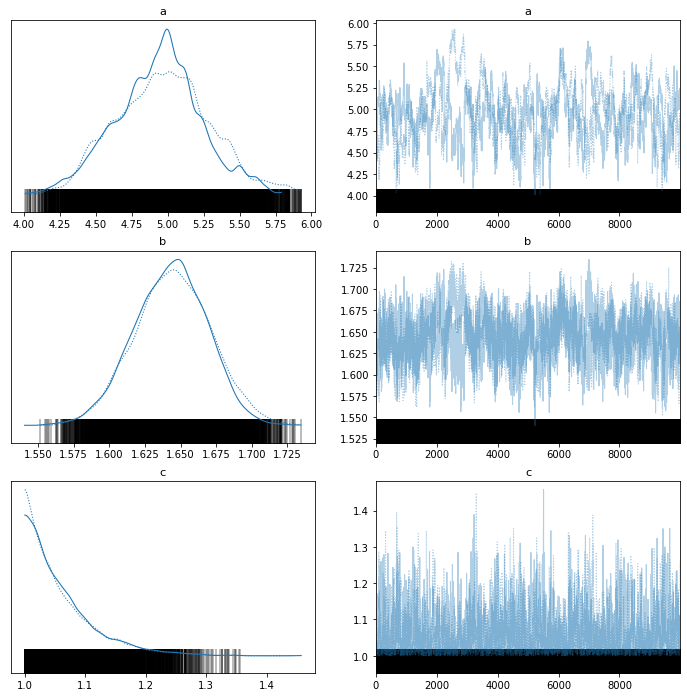

In [60]:
trace1 = tfp_trace_to_arviz([sam,tra],['a','b','c'])
az.plot_trace(trace1,figsize=(12,12));

In [33]:
Samples=np.concatenate([x.numpy().reshape([10000,num_chains]) for x in sam],axis=1)

(0.0, 5000.0)

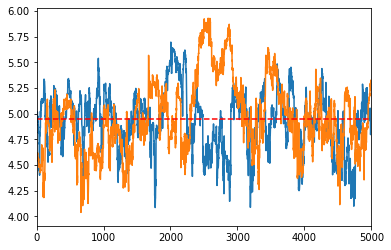

In [72]:
import matplotlib.pyplot as plt
plt.plot(range(nb+ns),np.array(states[0][0][0]).reshape(nb+ns))
plt.plot(range(nb+ns),np.array(states[1][0][0]).reshape(nb+ns))
plt.axhline(test_x[0,0],ls='--',c='red')
plt.xlim([0,5000])

In [ ]:


p=sns.displot(Samples[:,0],kind="kde",legend=False)
plt.axvline(test_x[0,0],color='red')
p.set_xlabels('A')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

p=sns.displot(Samples[:,1],kind="kde",legend=False)
plt.axvline(test_x[0,1],color='red')
p.set_xlabels('B')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

p=sns.displot(Samples[:,20:30],kind="kde",legend=False)
plt.axvline(test_x[0,2],color='red')
p.set_xlabels('C')